### В этом ноутбуке показано, как использовать нейросеть, прогнать через неё картинку и посчитать размеры пузырей.

In [1]:
import json

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './PraNet/')

In [3]:
import matplotlib.pyplot as plt

## I Dataset loading

In [4]:
def flood_fill(edge, dots):
    attempt = 1
    sign = 1
    max_square = 0
    the_best = None
    while attempt <= 10 and len(dots) > attempt:
        dot1 = dots[0]
        dot2 = dots[min(attempt, len(dots)-1)]
        dot = ((dot1[0]+dot2[0])//2,(dot1[1]+dot2[1])//2)
        dot = [max(0, dot[0]), max(0,dot[1])]
        dot = (400,400) # (min(dot[0],edge.shape[0]-1), min(dot[1], edge.shape[1]-1))
        
        im_flood_fill = edge.copy()
        h, w = edge.shape[:2]
        mask = np.zeros((h + 2, w + 2), np.uint8)
        im_flood_fill = im_flood_fill.astype("uint8")

        im_flood_fill=cv.floodFill(im_flood_fill, mask, dot, 1)[1].astype('float')
        if np.mean(im_flood_fill) > 0.85: # and np.mean(im_flood_fill) < 0.85:
            im_flood_fill = 1 - im_flood_fill
        elif im_flood_fill[0,0] > 0 or im_flood_fill[-1,-1] > 0 or im_flood_fill[-1,0] > 0 or im_flood_fill[0,-1] > 0:  # these points should be defintely zero!
            im_flood_fill[:] = 0
        
        if max_square < np.mean(im_flood_fill):
            max_square = np.mean(im_flood_fill)
            the_best = im_flood_fill
        #if np.mean(im_flood_fill) > 0.0007:
            #print(np.mean(im_flood_fill))
        #return im_flood_fill
        
        attempt += 1
        #sign = (-1) * sign
    
    #print("Faul")
    return the_best


def make_seg_map(seg_map, edges, x,y):
    l = list(zip(x,y))
    #|print(len(l))
    vectors = []
    dots = []
    
    edge = np.zeros(seg_map.shape[0:2])
    #edge[0,:] = 1
    #edge[:,0] = 1
    #edge[-1,:] = 1
    #edge[:,-1] = 1
    
    for i in range(1, len(l)+1):
        x1 = l[i-1][0]
        y1 = l[i-1][1]
        if i == len(l):
            x2 = l[0][0]
            y2 = l[0][1]
        else:
            x2 = l[i][0]
            y2 = l[i][1]


        dots.append((int(x1),int(y1)))

        ls = np.linspace((y1,x1), (y2,x2),num=2*int(np.sqrt((x2-x1)**2+(y2-y1)**2)))
        #print(ls)
        for ll in ls:
            #print(ll[0])
            ll = [int(ll[0]), int(ll[1])]
            ll[0] = max(0, ll[0])
            ll[1] = max(0, ll[1])
            
            ll[0] = min(edge.shape[0]-1, ll[0])
            ll[1] = min(edge.shape[1]-1, ll[1])
            edge[ll[0], ll[1]] = 1.0
       
        
    
    im_flood_fill = flood_fill(edge, dots)
    
    edges += edge
    #if np.mean(im_flood_fill > 0.0005):
        
    
    #print(im_flood_fill.mean())
    if im_flood_fill is not None:
        seg_map += im_flood_fill
    #plt.imshow(im_flood_fill)
    return seg_map, edges
    #print(im_flood_fill)

In [5]:
import os

In [6]:
imgs = [x[:-4] for x in os.listdir("./dataset/") if 'jpg' in x]

In [7]:
dataset=[]

In [8]:
import cv2 as cv

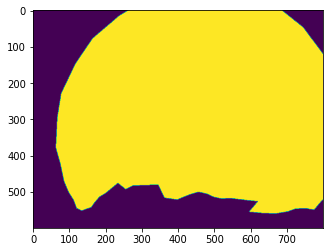

In [9]:
import numpy as np
index = np.random.choice(len(imgs))
img = plt.imread("./dataset/"+imgs[index]+".jpg")

with open("./dataset/"+imgs[index]+".json", "r") as file:
    ann = json.load(file)

import numpy as np
plt.imshow(img)
seg_map = np.zeros(img.shape[0:2])
edges = np.zeros(img.shape[0:2])
for i in range(0, len(ann['annotations'])):
    x=ann['annotations'][i]['segmentation'][0][::2]
    y=ann['annotations'][i]['segmentation'][0][1::2]
    x.append(x[0])
    y.append(y[0])
    seg_map, edges=make_seg_map(seg_map, edges, x,y)
    #plt.plot(x,y, c='white')
    #break
seg_map=np.where(seg_map>1,1, seg_map)
plt.imshow(seg_map)

In [10]:
import torch
img_copy=np.vstack([img, np.zeros((72,800,3))])  # for the sake of nn model 
img_torch = torch.from_numpy(img_copy.transpose(2,0,1))[None]/255
img_torch = img_torch.type(torch.FloatTensor)
del img_copy

In [11]:
import torch
from lib.PraNet_Res2Net import PraNet

In [12]:
net = PraNet().float().eval()

In [13]:
# # ensure that size is the right one
# h=net(Train[:1,:3].cuda())
# assert h.shape == (1,1,224,224)

In [14]:
net.load_state_dict(torch.load("./models/model_weights_0.6000_0.9248.save", map_location='cuda'))

<All keys matched successfully>

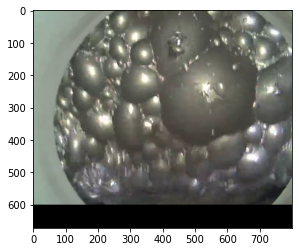

In [15]:
plt.imshow(img_torch[0].numpy().transpose(1,2,0))

In [16]:
from torch import nn 


def handle_by_crops(images, network, dsr_size, margin_size, device='cpu'):
    #print(images.shape)
    height = images.shape[-2]  # numpy has opposite dimension order
    width = images.shape[-1]
    lines = []
    network.to(device=device)
    x_prev = 0
    sigmoid = nn.Sigmoid()
    for x in range(dsr_size, height+dsr_size - 2 * margin_size - 1, dsr_size - 2 * margin_size):
        x = min(x, height)
        line = []
        y_prev = 0
        for y in range(dsr_size, width+dsr_size - 2 * margin_size - 1, dsr_size - 2*margin_size):
            y = min(y, width)
            img_cropped = images[:,:,x-dsr_size:x, y - dsr_size: y]
            img_cropped = img_cropped.to(device=device)
            
            
            pred = network(img_cropped)
            # the sum is the best to use (see notebook best_way_to_threshold)
            mask = sigmoid(pred[0] + pred[1] + pred[2] + pred[3])  
            mask = mask[:,0].detach().cpu().numpy()
            if y - dsr_size != 0:
                mask = mask[:,:,margin_size:]

            if y != width:
                mask = mask[:,:,:-margin_size]
            else:
                mask = mask[:,:,y_prev-(y-dsr_size + margin_size):]


            if x != height:
                mask = mask[:,:-margin_size]
            
            #print(mask.shape)
            #print()
            line.append(mask)
            y_prev = y - margin_size
            
            #break

        lines.append(np.concatenate(line,axis=2))
        x_prev =  x - margin_size
        #break
        
    result_mask = np.concatenate(lines, axis=1)
    #print(result_mask.shape)
    return result_mask

In [17]:
%%time
res = handle_by_crops(img_torch, net.eval(), 672, 224,'cuda')[0, :-72]

CPU times: user 188 ms, sys: 7.52 ms, total: 195 ms
Wall time: 124 ms


/home/boyarintsev.artem/catboost/venv/lib/python3.6/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/boyarintsev.artem/catboost/venv/lib/python3.6/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


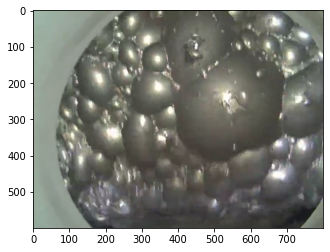

In [18]:
plt.imshow(img)

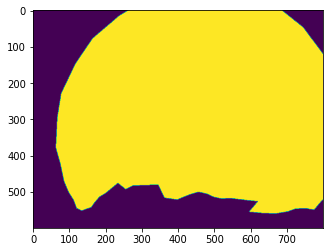

In [19]:
plt.imshow(seg_map)

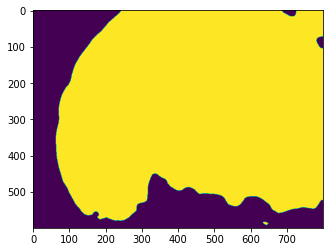

In [20]:
plt.imshow(res>0.8)

In [21]:
hsv_img = cv.cvtColor(img, cv.COLOR_RGB2HSV)

In [22]:
ret, thresh2 = cv.threshold(hsv_img[:,:,2], 180, 255, cv.THRESH_BINARY_INV)

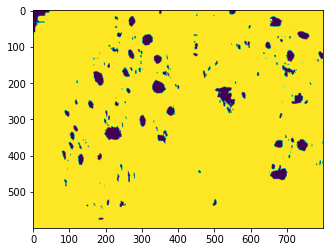

In [23]:
plt.imshow(thresh2)

In [24]:
kernel = np.ones((3,3))
thresh3=cv.dilate(thresh2,kernel)

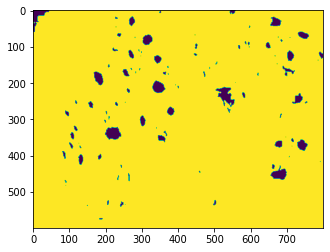

In [25]:
plt.imshow(thresh3)

In [26]:
contours, hieracy = cv.findContours(thresh3 , cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
len(contours)

103

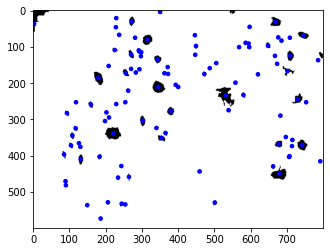

In [27]:
cX = -1
cY = -1

#plt.imshow(img_threshold,'gray')

figure, axes = plt.subplots()
axes.imshow(thresh3,'gray')

centers = []
for c in contours:
    M = cv.moments(c)
    if M["m00"] <= 1e-6:
        continue
    
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    #print(cX,cY)
    circle = plt.Circle((cX, cY), 5, color='b')
    area = cv.contourArea(c)
    if area < 5000:
        axes.add_patch(circle)
        centers.append((cX,cY,area))
    #cv.circle(thresh_img, (cX, cY), 3, (125, 125), -1)
plt.show()

In [28]:
from PIL import Image

In [29]:
seg_map_smalled = np.array(Image.fromarray((seg_map*255).astype('uint8')).resize((80,60)))

In [30]:
%%time
from collections import defaultdict

ones = np.where(seg_map_smalled)


d = defaultdict(lambda :0)
for i in range(0,len(ones[0])):
    x = ones[0][i]*10
    y = ones[1][i]*10
    
    min_distance=10000
    c_min = None
    for c in centers:
        area = c[2]
        distance = np.sqrt((c[1]-x)**2 + (c[0]-y)**2)/((area)**0.333)
        if distance < min_distance:
            min_distance = distance
            c_min = c
        
    d[c_min] +=100

CPU times: user 786 ms, sys: 0 ns, total: 786 ms
Wall time: 786 ms


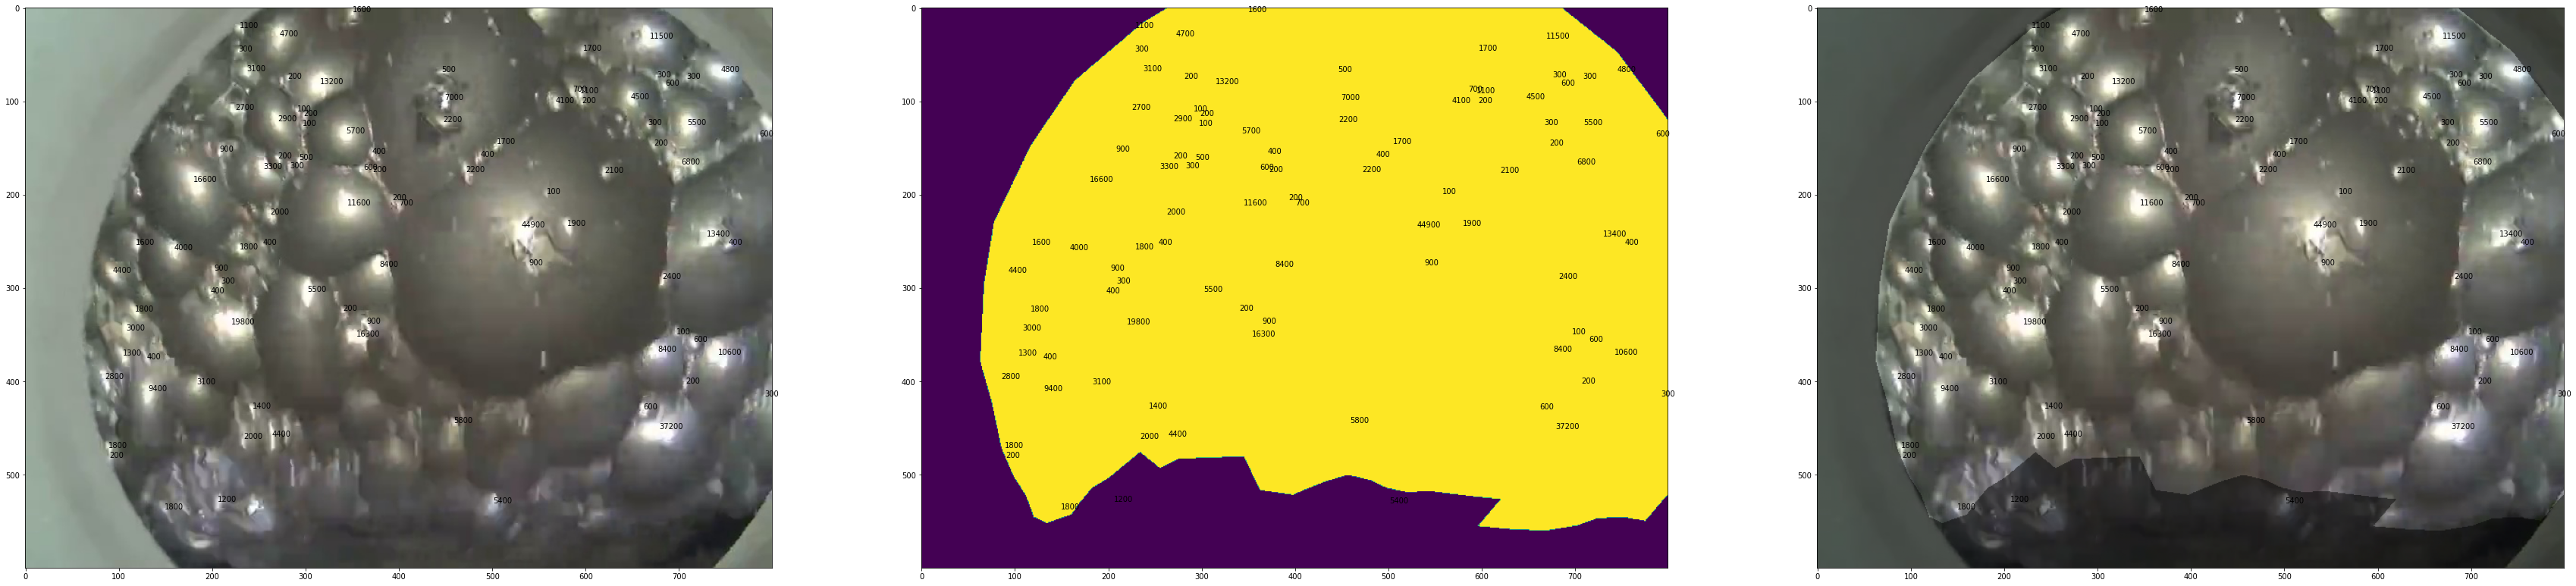

In [31]:
f,ax = plt.subplots(1,3,figsize=(60,60))
ax[0].imshow(img)
ax[1].imshow(seg_map)
ax[2].imshow(img/255*0.5 + img/255*seg_map[...,None]*0.5)
for key in d:
    c = key[0:2]
    ax[0].annotate(d[key],c)
    ax[1].annotate(d[key],c)
    ax[2].annotate(d[key],c)